In [1]:
from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import importlib
import mlflow as ml

import utillities as ut
import surv_bart as bmb

In [107]:
# importlib.reload(ut)
# importlib.reload(bmb)

<module 'surv_bart' from '/home/twj8/pymc_bart/surv_bart_pkg/surv_bart.py'>

In [240]:
EXP_ID = "553714660218339146"
EXP_NAME = "br1"
RUN_NAME = "r2"
SEED = 999

In [241]:
ml_exp = ml.set_experiment(experiment_id=EXP_ID)
run = ml.start_run(run_name = RUN_NAME, experiment_id= ml_exp.experiment_id)

In [13]:
# # set up mlflow
# experiment_name = "br1"
# if experiment_name:
#     print(f"getting experiment {experiment_name}")
#     ml_exp = ml.get_experiment_by_name(experiment_name)
# else:
#     ml_exp = ml.create_experiment(experiment_name)

getting experiment br1


# Create a simulation dataset

In [242]:
# generage the random number generator object
rng = np.random.default_rng(seed=SEED)

In [243]:
N = 10000
X_VARS = 10
VAR_CLASS = [2,10,3,1,2]
VAR_PROB = [0.5, 0.5, 0.5, 0.5, 0.5]
LAMBDA = "np.exp(-5 + .2*x_mat[:,0] + 0.01*np.log(x_mat[:,1]+0.00001) + 0.2*(x_mat[:,2] + x_mat[:,3] + x_mat[:,4]))" 
ALPHA_F = "3 + .1*x_mat[:,0]"
eos = 120
time_scale=20


# get SV
x_mat = ut.get_x_matrix(N=N, x_vars=X_VARS, VAR_CLASS=VAR_CLASS, VAR_PROB=VAR_PROB, rng=rng)
t_event, status, x_mat, true, true_scale = ut.sim_surv(x_mat, LAMBDA, ALPHA_F, eos, time_scale=time_scale, return_full=True, rng = rng)

Log the data generating params

In [244]:
sim_dict = {
    "N":N,
    "X_VARS":X_VARS,
    "VAR_CLASS": VAR_CLASS,
    "VAR_PROb": VAR_PROB,
    "LAMBDA" : LAMBDA,
    "ALPHA" : ALPHA_F,
    "EOS" : eos,
    "TIME_SCALE": time_scale,
    "SEED": seed
}

ml.log_params(sim_dict,)

In [245]:
# test
t_x_mat = ut.get_x_matrix(N=N, x_vars=X_VARS, VAR_CLASS=VAR_CLASS, VAR_PROB=VAR_PROB, rng=rng)
t_t_event, t_status, t_x_mat, t_true, t_true_scale = ut.sim_surv(t_x_mat, LAMBDA, ALPHA_F, eos, time_scale=time_scale, return_full=True, rng=rng)

Do not log the generated datasets as they can be relogged with the data generating params


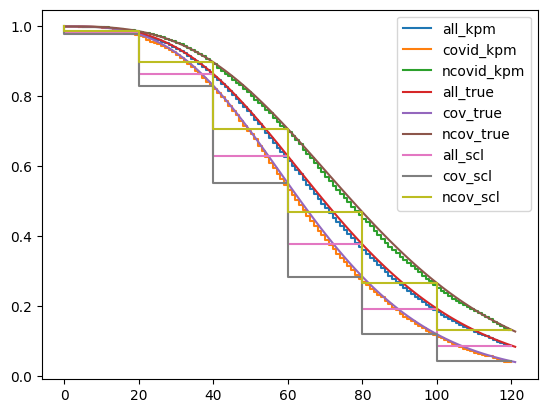

In [246]:
# create figure checks
fig = ut.quick_kpm_true(x_mat, status, t_event, true, true_scale)
ml.log_figure(fig, "sim_kpm_compare.png")

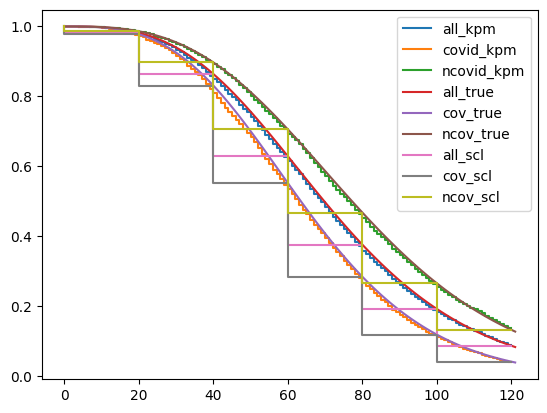

In [247]:
# create test figure checks
fig = ut.quick_kpm_true(t_x_mat, t_status, t_t_event, t_true, t_true_scale)
ml.log_figure(fig, "sim_kpm_compare_test.png")

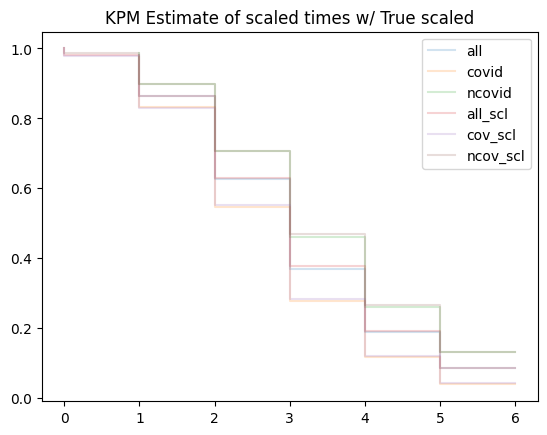

In [248]:
fig = ut.quick_kpm_true_scale(x_mat, status, t_event, true_scale, time_scale)
ml.log_figure(fig, "sim_kpm_scaled.png")

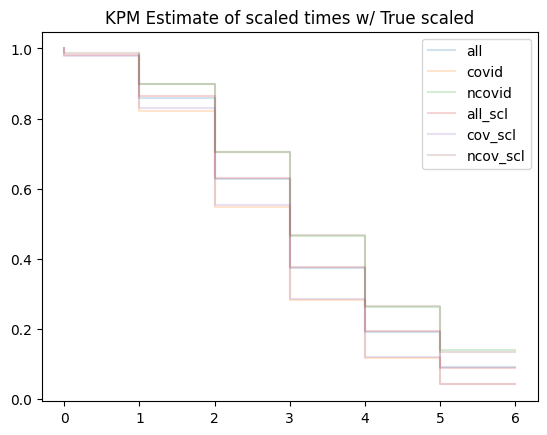

In [249]:
# test
fig = ut.quick_kpm_true_scale(t_x_mat, t_status, t_t_event, t_true_scale, time_scale)
ml.log_figure(fig, "sim_kpm_scaled_test.png")

In [250]:
mc_mask = (x_mat[:,0] == 1)
train_dict = {
    "N":status.shape[0],
    "minor class cases" :status[mc_mask].shape[0],
    "minor class events": status[mc_mask].sum(),
    "minor class ev prop": status[mc_mask].sum()/status[mc_mask].shape[0],
    "major class cases":status[~mc_mask].shape[0],
    "major class events" : status[~mc_mask].sum(),
    "major class ev prop": status[~mc_mask].sum()/status[~mc_mask].shape[0]
}

mc_mask = (t_x_mat[:,0] == 1)
test_dict = {
    "N":status.shape[0],
    "minor class cases" :t_status[mc_mask].shape[0],
    "minor class events": t_status[mc_mask].sum(),
    "minor class ev prop": t_status[mc_mask].sum()/t_status[mc_mask].shape[0],
    "major class cases":t_status[~mc_mask].shape[0],
    "major class events" : t_status[~mc_mask].sum(),
    "major class ev prop": t_status[~mc_mask].sum()/t_status[~mc_mask].shape[0]
}

# log these
print(train_dict)
print(test_dict)

ml.log_dict(train_dict, "train_dict.json")
ml.log_dict(test_dict, "test_dict.json")

{'N': 10000, 'minor class cases': 5002, 'minor class events': 4810.0, 'minor class ev prop': 0.9616153538584566, 'major class cases': 4998, 'major class events': 4336.0, 'major class ev prop': 0.867547018807523}
{'N': 10000, 'minor class cases': 5002, 'minor class events': 4800.0, 'minor class ev prop': 0.9596161535385845, 'major class cases': 4998, 'major class events': 4304.0, 'major class ev prop': 0.8611444577831132}


# Surv Bart Model

In [251]:
t_event2 = bmb.get_time_transform(t_event, time_scale=time_scale)
y_sk = bmb.get_y_sklearn(status, t_event2)
y_sk_coh, x_sk_coh, w_coh= bmb.get_case_cohort(y_sk, x_mat, prop = 1)
coh_y, coh_x, coh_w, coh_coords = bmb.surv_pre_train(y_sk_coh, x_sk_coh, w_coh)
x_tst, tst_coords = bmb.get_posterior_test(np.unique(y_sk_coh["Survival_in_days"]), x_sk_coh)

In [254]:
# intitialize models
model_dict = {"trees": 20,
    "split_rules": [
    "pmb.ContinuousSplitRule()",
    "pmb.OneHotSplitRule",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.OneHotSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()"
    ],
    "split_prior": [0.9,
                0.002,
                0.002,
                0.002,
                0.002,
                0.002,
                0.002,
                0.002,
                0.002,
                0.002,
                0.002]
}

sampler_dict = {
            "draws": 100,
            "tune": 100,
            "cores": 4,
            "chains": 4,
            "compute_convergence_checks": False
        }

# initialize bart
bart_model = bmb.BartSurvModel(model_config=model_dict, sampler_config=sampler_dict)

ml.log_params(model_dict)
ml.log_params(sampler_dict)

In [255]:
ml.log_dict({"model_dict":model_dict, "sampler_dict":sampler_dict}, "parameter_dict.json")

In [256]:
# fit model
bart_model.fit(coh_y, coh_x, coh_w, coh_coords)
# sample posterior
post = bart_model.sample_posterior_predictive(x_tst, tst_coords, extend_idata=True)
# get posterior data
prob = bmb.get_prob(post)
sv = bmb.get_survival(post)
# save idata and tree
bart_model.save(idata_name="test_idata1.pkl", all_tree_name="test_tree1.pkl")

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 45 seconds.
Sampling: [f]


In [257]:
ml.log_artifact("test_idata1.pkl")
ml.log_artifact("test_tree1.pkl")

In [258]:
# naive variable importance
vars_tree = bart_model.idata.sample_stats.variable_inclusion.values.reshape(400,-1)
vmean = vars_tree.mean(0)
var_dict = dict(zip(np.argsort(-vmean), -np.sort(-vmean)))
var_dict = dict([(str(k),v) for k,v in var_dict.items()])
print(var_dict)
ml.log_dict(var_dict, "variable_importance.json")
# save this

{'0': 2.16, '3': 0.7025, '5': 0.365, '1': 0.34, '4': 0.1875, '6': 0.1275, '7': 0.1075, '10': 0.0925, '2': 0.0775, '9': 0.0775, '8': 0.0675}


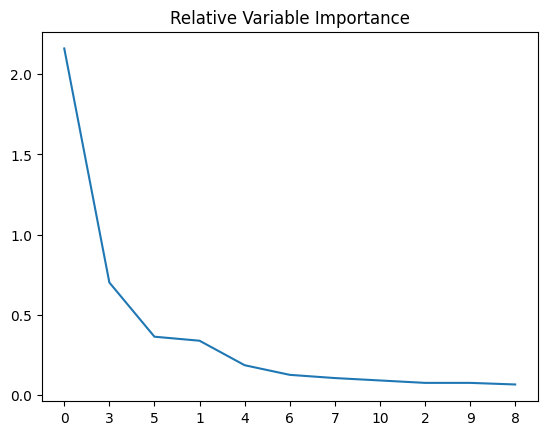

In [259]:
fig, ax = plt.subplots(1)
ax.plot(var_dict.keys(), var_dict.values())
ax.set_title("Relative Variable Importance")
ml.log_figure(fig, "Relative Variable Importance.png")

# Cox Model

Train a cox model for comparison purposes.

While the exp(coef) returned do not have associated confidence intervals, the point estimate can be used as an approximate comparison of variable importance between cox and bart models.

In [260]:
# cox model
cph_coef, cph_sv, cph_chz = ut.get_cph(y_sk, x_mat, x_mat)

{'exp coef': [1.582811606498878,
  1.003304225152193,
  1.5658609683032298,
  1.4886090617433185,
  1.5916310842337344,
  0.9946765813970544,
  0.9531511254187579,
  0.9821612703456878,
  1.0363203225861923,
  0.9783131234218216]}

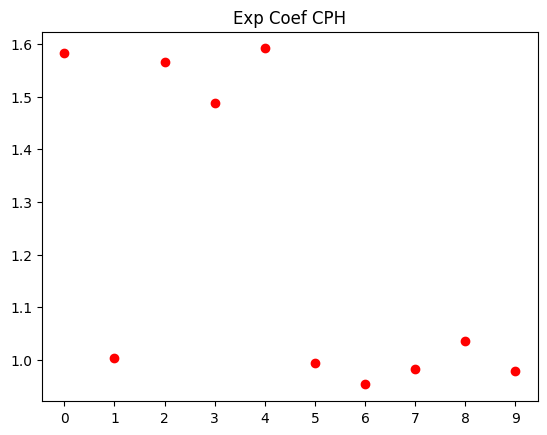

In [261]:

fig, ax = plt.subplots(1)
ax.plot(np.arange(0,cph_coef["exp coef"].shape[0]), cph_coef["exp coef"], "ro")
ax.set_xticks(np.arange(0, cph_coef["exp coef"].shape[0]))
ax.set_title("Exp Coef CPH")
cph_coef["exp coef"] = list(cph_coef["exp coef"])
ml.log_dict(cph_coef, "cph_coef.json")
ml.log_figure(fig, "Exp_Coef.png")
cph_coef

# Model Evaluations

Compare the estimated survival curves of the two models to the kpm estimator. 

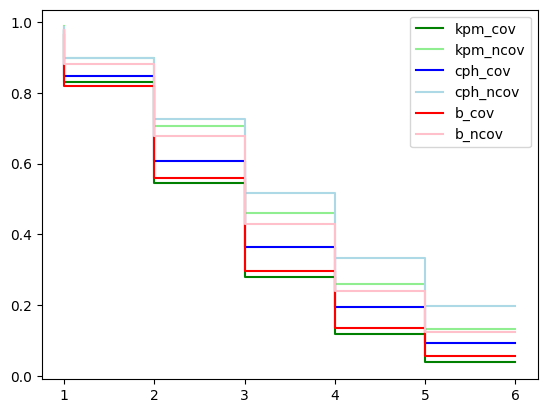

In [262]:
fig = ut.quick_kpm_plot(y_sk, msk=x_mat[:,0]==1, cph_sv=cph_sv, sv=sv)
ml.log_figure(fig, "Pred compare KM.png")

Get evaluations metrics including the cindex and brier score.

In [263]:
bart_met = ut.get_sv_metrics(sv, prob, y_sk_coh)
cph_met = ut.get_sv_metrics(cph_sv, cph_chz, y_sk)

# log these
print(bart_met)
print(cph_met)

{'cindex': [0.703, 0.705, 0.705, 0.704, 0.704, 0.703], 'bs': [[1.0, 2.0, 3.0, 4.0, 5.0], [0.017954187805952537, 0.10971032691238779, 0.202758585838199, 0.19250649759770883, 0.127231143597582]], 'ibs': 0.1444}
{'cindex': [0.706, 0.706, 0.706, 0.706, 0.706, 0.706], 'bs': [[1.0, 2.0, 3.0, 4.0, 5.0], [0.017870615005387523, 0.10960824463389342, 0.20303135768319533, 0.19463087248160726, 0.13038247928796246]], 'ibs': 0.1453}


In [264]:
ml.log_dict(bart_met, "train_bart_metrics.json")
ml.log_dict(cph_met, "train_cph_metrics.json")

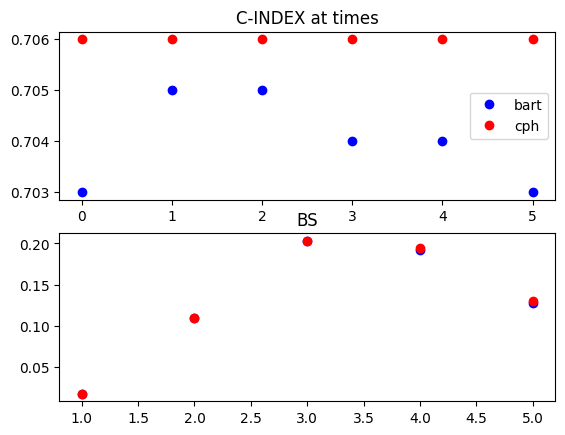

In [265]:
fig, ax = plt.subplots(2)
ar = np.arange(len(bart_met["cindex"]))
ax[0].plot(ar, bart_met["cindex"], "bo", label="bart")
ax[0].plot(ar, cph_met["cindex"], "ro", label="cph")
ax[0].legend()
ax[0].set_title("C-INDEX at times")

ar = bart_met["bs"][0]
bs = bart_met["bs"][1]
ax[1].plot(ar, bs, "bo")
bs = cph_met["bs"][1]
ax[1].plot(ar, bs, "ro")
ax[1].set_title("BS")

ml.log_figure(fig, "Train_CI_BS_metrics.png")

# Test

In [266]:
# Test
t_t_event2 = bmb.get_time_transform(t_t_event, time_scale=time_scale)
t_y_sk = bmb.get_y_sklearn(t_status, t_t_event2)
t_y_sk_coh, t_x_sk_coh, t_w_coh= bmb.get_case_cohort(t_y_sk, t_x_mat, 1)
t_x_tst, t_tst_coords = bmb.get_posterior_test(np.unique(t_y_sk_coh["Survival_in_days"]), t_x_sk_coh)

t_post = bart_model.sample_posterior_predictive(t_x_tst, t_tst_coords, extend_idata=False)
t_prob = bmb.get_prob(t_post)
t_sv = bmb.get_survival(t_post)

# cox
t_cph_coef, t_cph_sv, t_cph_chz = ut.get_cph(y_sk, x_mat, t_x_mat)


Sampling: [f]


Test dataset evaluation metrics.

{'cindex': [0.703, 0.703, 0.703, 0.703, 0.702, 0.701], 'bs': [[1.0, 2.0, 3.0, 4.0, 5.0], [0.017455292949972282, 0.11374521778942204, 0.2027607285572807, 0.19349245413169705, 0.127073179529254]], 'ibs': 0.1456}
{'cindex': [0.705, 0.705, 0.705, 0.705, 0.705, 0.705], 'bs': [[1.0, 2.0, 3.0, 4.0, 5.0], [0.017330207134193573, 0.11381931779142541, 0.20278321522183024, 0.1946279028976526, 0.12948952610499853]], 'ibs': 0.1462}


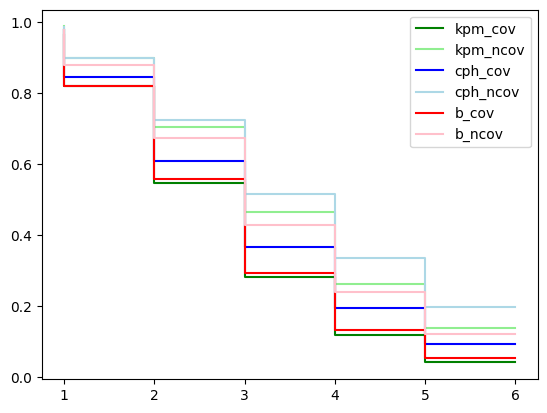

In [267]:
fig = ut.quick_kpm_plot(t_y_sk, t_x_mat[:,0]==1, t_cph_sv, t_sv)
# save this
t_bart_met = ut.get_sv_metrics(t_sv, t_prob, t_y_sk_coh, y_sk_coh)
t_cph_met = ut.get_sv_metrics(t_cph_sv, t_cph_chz, t_y_sk, y_sk)

print(t_bart_met)
print(t_cph_met)
ml.log_figure(fig, "Test compare KM.png")

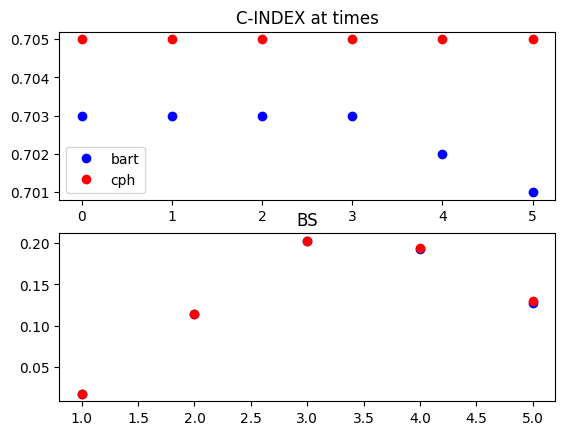

In [268]:
fig, ax = plt.subplots(2)
ar = np.arange(len(t_bart_met["cindex"]))
ax[0].plot(ar, t_bart_met["cindex"], "bo", label="bart")
ax[0].plot(ar, t_cph_met["cindex"], "ro", label="cph")
ax[0].legend()
ax[0].set_title("C-INDEX at times")

ar = t_bart_met["bs"][0]
bs = t_bart_met["bs"][1]
ax[1].plot(ar, bs, "bo")
bs = t_cph_met["bs"][1]
ax[1].plot(ar, bs, "ro")
ax[1].set_title("BS")

ml.log_figure(fig, "Test_CI_BS_metrics.png")

# True Evaluation 

In [269]:
tmp_times = [0,1,2,3,4,5]
b_true_eval = ut.get_true_rmse_bias(
    true_scale["sv_true"][:,1:], 
    sv,
    tmp_times
    )

cph_true_eval = ut.get_true_rmse_bias(
    true_scale["sv_true"][:,1:], 
    cph_sv,
    tmp_times
    )


t_b_true_eval = ut.get_true_rmse_bias(
    t_true_scale["sv_true"][:,1:], 
    t_sv,
    tmp_times
    )

t_cph_true_eval = ut.get_true_rmse_bias(
    t_true_scale["sv_true"][:,1:], 
    t_cph_sv,
    tmp_times
    )

print(b_true_eval)
print(cph_true_eval)
print(t_b_true_eval)
print(t_cph_true_eval)

{'rmse': [0.0118, 0.0299, 0.066, 0.079, 0.0666, 0.0458], 'bias': [0.0108, 0.0129, 0.0104, 0.0132, 0.004, -0.0037], 'time_col': [0, 1, 2, 3, 4, 5]}
{'rmse': [0.0034, 0.0288, 0.0659, 0.0816, 0.0797, 0.065], 'bias': [0.0002, -0.0089, -0.0376, -0.065, -0.0722, -0.0575], 'time_col': [0, 1, 2, 3, 4, 5]}
{'rmse': [0.0121, 0.0303, 0.0664, 0.0794, 0.0671, 0.0468], 'bias': [0.0111, 0.0146, 0.0133, 0.0156, 0.0066, -0.0003], 'time_col': [0, 1, 2, 3, 4, 5]}
{'rmse': [0.0034, 0.0284, 0.0656, 0.0817, 0.0797, 0.0648], 'bias': [0.0003, -0.0088, -0.0375, -0.0651, -0.0722, -0.0573], 'time_col': [0, 1, 2, 3, 4, 5]}


In [270]:
true_eval_dict = {
    "b_train":b_true_eval,
    "cph_trian": cph_true_eval,
    "b_test": t_b_true_eval,
    "cph_test": t_cph_true_eval
}

ml.log_dict(true_eval_dict, "true_eval_dict.json")

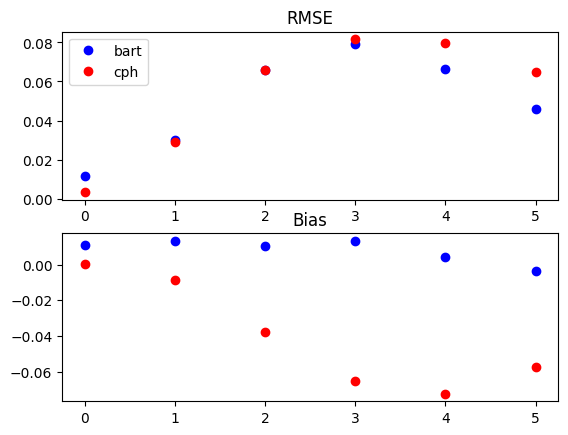

In [271]:
fig, ax = plt.subplots(2)
ax[0].plot(b_true_eval["time_col"], b_true_eval["rmse"], "bo", label = "bart")
ax[0].plot(cph_true_eval["time_col"], cph_true_eval["rmse"], "ro", label = "cph")
ax[1].plot(b_true_eval["time_col"], b_true_eval["bias"], "bo")
ax[1].plot(cph_true_eval["time_col"], cph_true_eval["bias"], "ro")
ax[0].legend()
ax[0].set_title("RMSE")
ax[1].set_title("Bias")

ml.log_figure(fig, "True vs Train Pred Metrics.png")


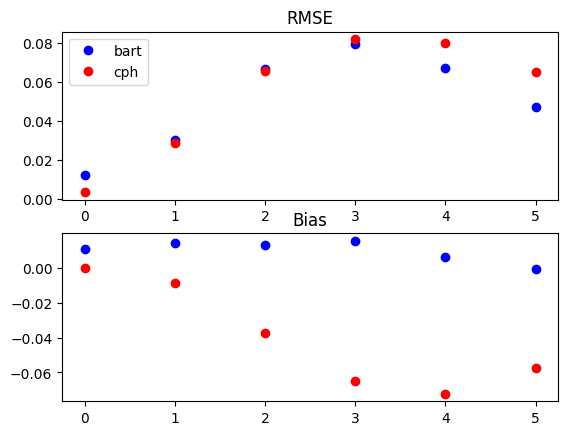

In [272]:
fig, ax = plt.subplots(2)
ax[0].plot(t_b_true_eval["time_col"], t_b_true_eval["rmse"], "bo", label = "bart")
ax[0].plot(t_cph_true_eval["time_col"], t_cph_true_eval["rmse"], "ro", label = "cph")
ax[1].plot(t_b_true_eval["time_col"], t_b_true_eval["bias"], "bo")
ax[1].plot(t_cph_true_eval["time_col"], t_cph_true_eval["bias"], "ro")
ax[0].legend()
ax[0].set_title("RMSE")
ax[1].set_title("Bias")

ml.log_figure(fig, "True vs Test Pred Metrics.png")

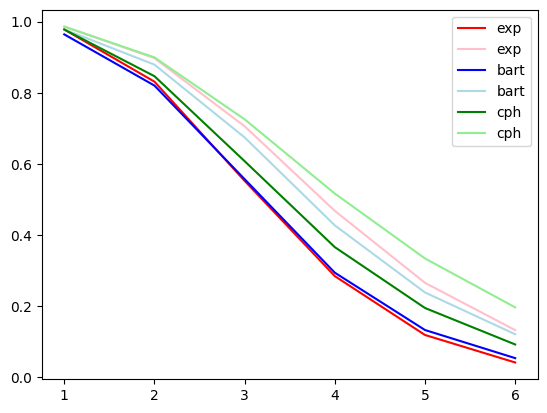

In [273]:
msk = t_x_mat[:,0] == 1

m1 = t_true_scale["sv_true"][msk,1:].mean(axis=0)
m1_ = t_true_scale["sv_true"][~msk,1:].mean(axis=0)
m2 = t_sv[msk,:].mean(axis=0)
m2_ = t_sv[~msk,:].mean(axis=0)
m3 = t_cph_sv[msk,:].mean(axis=0)
m3_ = t_cph_sv[~msk,:].mean(axis=0)


fig, ax = plt.subplots(1)
tmp_times = [1,2,3,4,5,6]
ax.plot(tmp_times, m1, color = "red", label = "exp")
ax.plot(tmp_times, m1_, color= "pink", label = "exp")
ax.plot(tmp_times, m2, color = "blue", label="bart")
ax.plot(tmp_times, m2_, color = "lightblue", label= "bart")
ax.plot(tmp_times, m3, color = "green", label= "cph")
ax.plot(tmp_times, m3_, color = "lightgreen", label = "cph")

ax.legend()

ml.log_figure(fig, "Test Exp vs Pred Mean Stratified SV.png")


In [274]:
ml.end_run()